In [8]:
#import Library
import os
import xarray as xr
import rioxarray as rxr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

#### Stack all chirps dataset

In [2]:
#Create fuction to stack all precipitation dataset
def stack_chirps_data(data_folder):
    file_paths = glob(os.path.join(data_folder, "*.tif"))
    
    all_layers = []
    
    #Extract the year directly from the filename
    for path in file_paths:
        file_name = os.path.basename(path)
        year = int(file_name.split('_')[1].split('.')[0])

        da = rxr.open_rasterio(path, masked=True)
        
        time_coords = pd.date_range(f"{year}-01-01", periods=len(da.band), freq='MS')
        
        da = da.rename({'band': 'time'})
        da = da.assign_coords(time=time_coords)
        
        all_layers.append(da)

    #Concatenate all files and sort them automatically by the time coordinate
    ds = xr.concat(all_layers, dim='time').sortby('time').to_dataset(name='precipitation')
    
    #Add simple metadata attributes
    ds.attrs.update({
        'units': 'mm/month', 
        'source': 'CHIRPS',
        'description': 'Monthly precipitation data stacked from yearly multi-band TIFFs'
    })
    
    #Summary Output
    print(f"Successfully merged {len(file_paths)} files.")
    print(f"Time range: {ds.time.dt.year.min().values} - {ds.time.dt.year.max().values}")
    
    return ds

In [ ]:
#stack chirps dataset
data_folder = r"D:\Project\drought\Data Raster\clip_chirps"

chirps_ds = stack_chirps_data(data_folder)
chirps_ds

#### Visualization of Monthly Precipitation

In [ ]:
#Culculate mean precipitation for each month
pr_mean = chirps_ds['precipitation'].mean(dim =['y', 'x'])

# convert to dataframe
df_mean = pr_mean.to_dataframe().reset_index()

# add new colom
df_mean['year'] = df_mean['time'].dt.year
df_mean['month'] = df_mean['time'].dt.month

#pivot dataset (wide/matrix format)
monthly_mean = df_mean.pivot(index='month', columns = 'year', values='precipitation')
monthly_mean

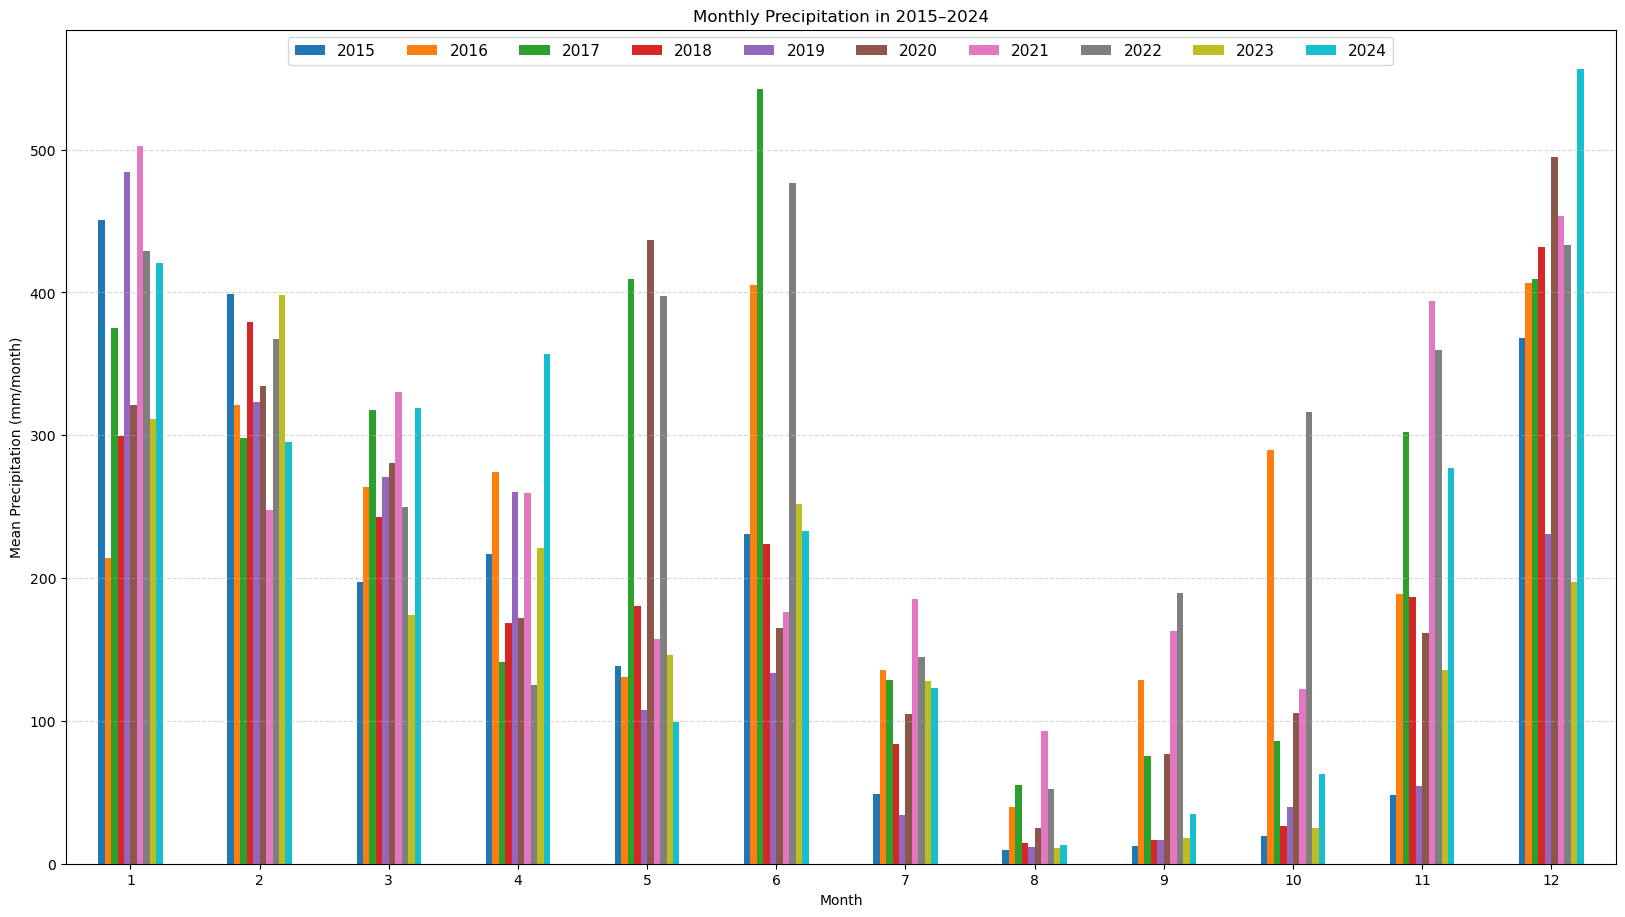

In [5]:
#bar char visualization
monthly_mean.plot(kind='bar', figsize=(20,6))

plt.xlabel("Month")
plt.ylabel("Mean Precipitation (mm/month)")
plt.title("Monthly Precipitation in 2015–2024")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(
    ncol=10,
    loc="upper center",
    frameon=True,
    fontsize=11,
)

plt.subplots_adjust(top=1.5)
plt.show()

#### Visualization of Mean Annual Precipitation

In [6]:
pr_annual = chirps_ds.sortby('time')
pr_annual_mean = pr_annual.resample(time = 'YE').mean()

<Figure size 700x400 with 0 Axes>

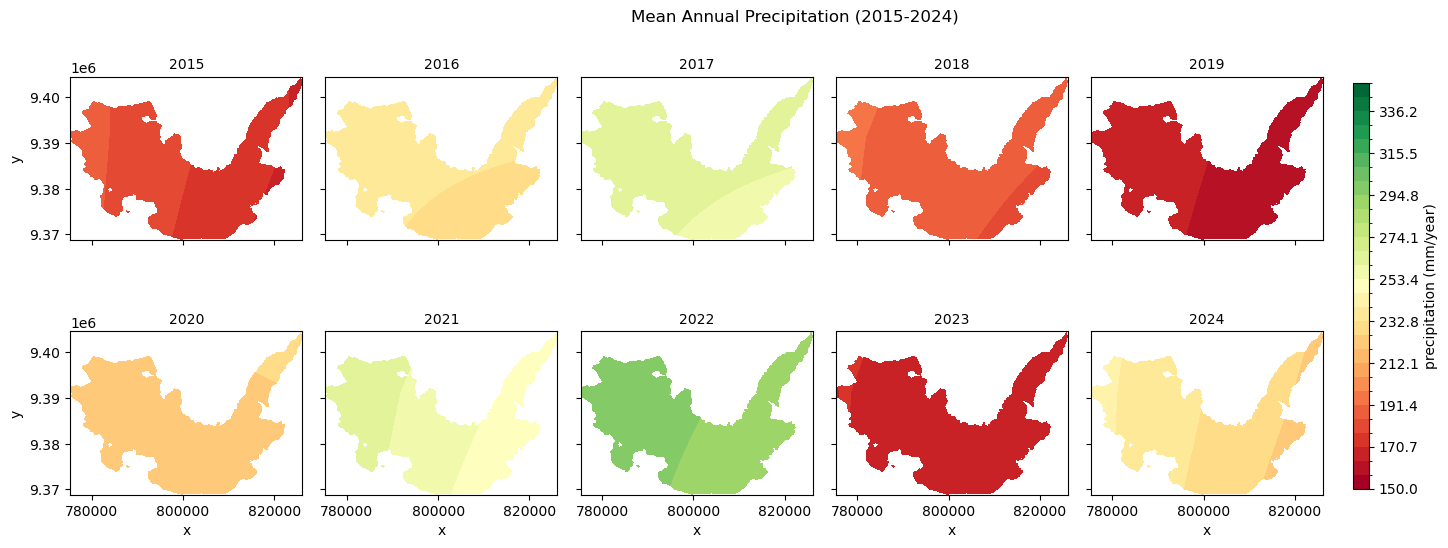

In [ ]:
# Determine the figure size at the beginning
fig = plt.figure(figsize=(7, 4)) 

vis_pr = pr_annual_mean.precipitation.assign_coords(time=pr_annual_mean.time.dt.year).plot.contourf(
    x = 'x',
    y = 'y',
    col = 'time',
    col_wrap = 5,
    robust = True,
    cmap = 'RdYlGn',
    vmin = 150,
    vmax = 350,
    levels = 30, 
    add_colorbar = True,
    cbar_kwargs = {"shrink": 0.8, "aspect": 25, "label":'precipitation (mm/year)'}
)

for ax in vis_pr.axs.flat:
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)

vis_pr.fig.subplots_adjust(wspace=0.1, hspace=0.01, right=0.83)
vis_pr.set_titles("{value}")

plt.suptitle('Mean Annual Precipitation (2015-2024)', y=0.98)
plt.show()

#### Culculate PCI (Precipitation Condition Index)

PCI = (TRMM - TRMMmin) / (TRMMmax - TRMMmin)

In [ ]:
#culculate trmm min and max
pr_annual_mean = pr_annual.precipitation.resample(time ='YE').mean()

trmm_max = pr_annual_mean.max(dim='time')
trmm_min = pr_annual_mean.min(dim='time')
print(f'trmm_max {trmm_max.max().values:.2f} mm/month')
print(f'trmm_min {trmm_min.min().values:.2f} mm/month')

trmm_max 301.33 mm/month
trmm_min 158.07 mm/month


In [ ]:
#pci formula
pci = (pr_annual_mean - trmm_min)/(trmm_max-trmm_min)

In [ ]:
# Define the list of years for calculation (from 2015 to 2024)
years = [str(y) for y in range(2015, 2025)]

# Dictionary to store the statistical results (optional)
pci_stats = {}

for year in years:
    # Select the PCI data for a specific year and remove single-dimensional entries
    pci_year = pci.sel(time=year).squeeze()
    
    # Calculate pixel-based statistics for the selected year
    min_val = pci_year.min().item()
    max_val = pci_year.max().item() 
    avg_val = pci_year.mean().item() 
    
    # Store the results in the dictionary
    pci_stats[year] = {'min': min_val, 'max': max_val, 'mean': avg_val}
    
    # Print the summary for each year
    print(f"Year {year} | Min: {min_val:.4f}, Max: {max_val:.4f}, Mean: {avg_val:.4f}")


#### Save PCI

In [27]:
# Example: Save a specific year's map to a GeoTIFF file (e.g., for the year 2015)
pci.sel(time='2015').squeeze().rio.write_crs('EPSG:32750', inplace=True).rio.to_raster("PCI_Jeneponto_2015.tif")